# 1. Import Library


In [1]:
# type: ignore

import os
import random
import pathlib

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# 2. Data Understanding/Preparation


In [2]:
base_dir = "./Dataset/dataset-sendiri/"
train_dir = os.path.join(base_dir, "Training")
test_dir = os.path.join(base_dir, "Test")

### Menghitung jumlah gambar yang ada pada folder training dan test dan membuat DataFrame


In [3]:
data_dir = pathlib.Path(train_dir) 
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) 
print(class_names)

['Alpukat' 'Jambu' 'Jeruk' 'Lemon' 'Nanas' 'Pisang' 'Salak' 'Semangka']


In [4]:
def count_images_in_directory(directory):
    total_images = 0
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.jpg') or file.endswith('.png'):
                total_images += 1
    return total_images

train_image_count = count_images_in_directory(train_dir)
test_image_count = count_images_in_directory(test_dir)

print("Total gambar pada folder training:", train_image_count)
print("Total gambar pada folder test:", test_image_count)

Total gambar pada folder training: 3200
Total gambar pada folder test: 1120


([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'Alpukat'),
  Text(1, 0, 'Jambu'),
  Text(2, 0, 'Jeruk'),
  Text(3, 0, 'Lemon'),
  Text(4, 0, 'Nanas'),
  Text(5, 0, 'Pisang'),
  Text(6, 0, 'Salak'),
  Text(7, 0, 'Semangka')])

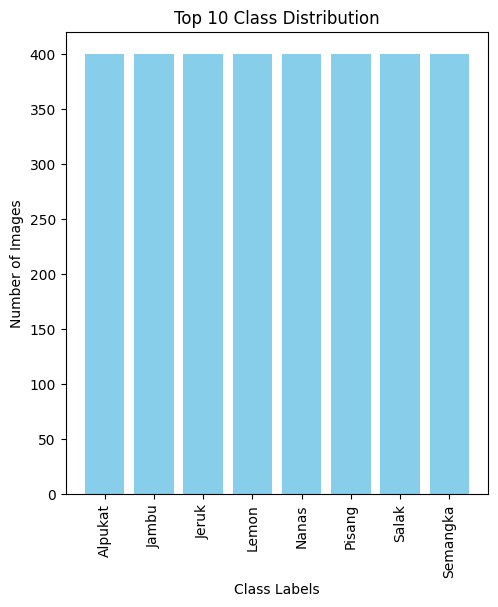

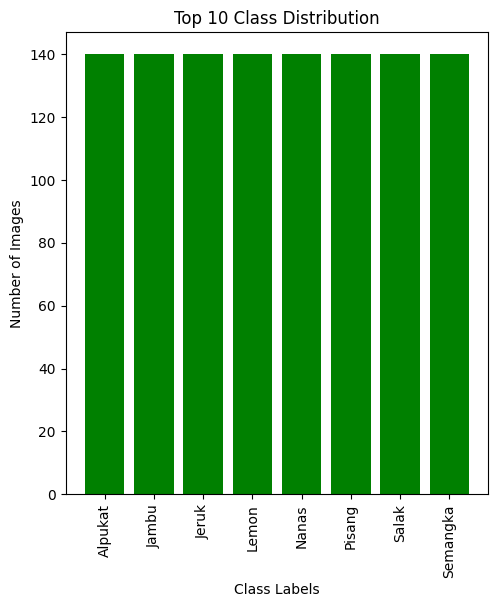

In [5]:
# Function to count the number of images in each class
def count_images_per_class(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

# Count the number of images per class in the training directory
train_class_counts = count_images_per_class(data_dir)
test_class_counts = count_images_per_class(test_dir)

# Sort class counts by their values
train_sorted_class_counts = dict(sorted(train_class_counts.items(), key=lambda item: item[1]))
test_sorted_class_counts = dict(sorted(test_class_counts.items(), key=lambda item: item[1]))

# Take the top 10 and bottom 10 classes
train_top_10_classes = dict(list(train_sorted_class_counts.items())[-10:])
test_top_10_classes = dict(list(test_sorted_class_counts.items())[-10:])

# Plot the top 10 classes train
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(train_top_10_classes.keys(), train_top_10_classes.values(), color='skyblue')
plt.title('Top 10 Train Class Distribution')
plt.xlabel('Class Labels')
plt.ylabel('Number of Images')
plt.xticks(rotation=90)  # Rotate x-axis labels vertically

# Plot the top 10 classes test
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(test_top_10_classes.keys(), test_top_10_classes.values(), color='green')
plt.title('Top 10 Test Class Distribution')
plt.xlabel('Class Labels')
plt.ylabel('Number of Images')
plt.xticks(rotation=90)  # Rotate x-axis labels vertically


In [6]:
def create_dataframe(data_path):
    df = []
    for c in os.listdir(data_path):
        class_folder = os.path.join(data_path, c)
        for f in os.listdir(class_folder):
            f_path = os.path.join(class_folder, f)
            if f_path.endswith('jpg'):
                df.append([f_path, c])
    return pd.DataFrame(df, columns=('filename', 'class'))

classes = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])

df_train = create_dataframe(train_dir)
df_test = create_dataframe(test_dir)

df_train, df_test

(                                               filename     class
 0     ./Dataset/dataset-sendiri/Training\Alpukat\1 (...   Alpukat
 1     ./Dataset/dataset-sendiri/Training\Alpukat\1 (...   Alpukat
 2     ./Dataset/dataset-sendiri/Training\Alpukat\1 (...   Alpukat
 3     ./Dataset/dataset-sendiri/Training\Alpukat\1 (...   Alpukat
 4     ./Dataset/dataset-sendiri/Training\Alpukat\1 (...   Alpukat
 ...                                                 ...       ...
 3195  ./Dataset/dataset-sendiri/Training\Semangka\1 ...  Semangka
 3196  ./Dataset/dataset-sendiri/Training\Semangka\1 ...  Semangka
 3197  ./Dataset/dataset-sendiri/Training\Semangka\1 ...  Semangka
 3198  ./Dataset/dataset-sendiri/Training\Semangka\1 ...  Semangka
 3199  ./Dataset/dataset-sendiri/Training\Semangka\1 ...  Semangka
 
 [3200 rows x 2 columns],
                                                filename     class
 0     ./Dataset/dataset-sendiri/Test\Alpukat\45_100.jpg   Alpukat
 1     ./Dataset/dataset-sendiri/T

### Memisahkan data train sebesar 10%/20% untuk data validasi

dan menjadikan perbandingan(split_dataset) menjadi 80:20 dan 70:30


In [7]:
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=42)

df_val

,filename,class
2384,./Dataset/dataset-sendiri/Training\Pisang\1 (8...,Pisang
2538,./Dataset/dataset-sendiri/Training\Salak\1 (22...,Salak
2176,./Dataset/dataset-sendiri/Training\Pisang\1 (2...,Pisang
897,./Dataset/dataset-sendiri/Training\Jeruk\1 (18...,Jeruk
214,./Dataset/dataset-sendiri/Training\Alpukat\1 (...,Alpukat
...,...,...
2936,./Dataset/dataset-sendiri/Training\Semangka\1 ...,Semangka
1468,./Dataset/dataset-sendiri/Training\Lemon\1 (34...,Lemon
561,./Dataset/dataset-sendiri/Training\Jambu\1 (24...,Jambu
282,./Dataset/dataset-sendiri/Training\Alpukat\1 (...,Alpukat


### Menampilkan data


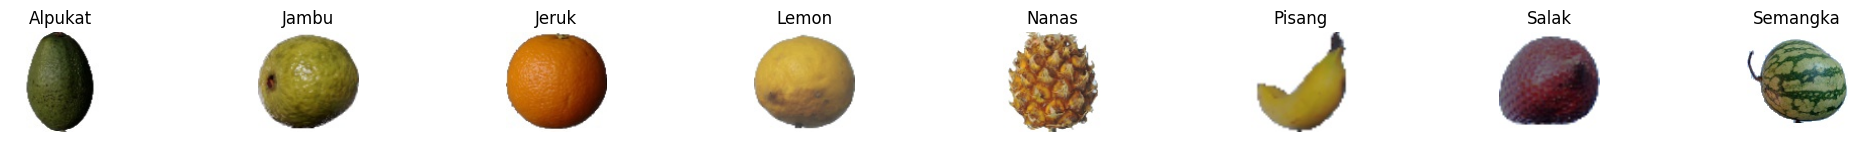

In [8]:
def view_random_image(target_dir, target_class):
    target_folder = os.path.join(target_dir, target_class)
    random_image = random.choice(os.listdir(target_folder))
    img = mpimg.imread(os.path.join(target_folder, random_image))

    return img

rows = 17
cols = 8

plt.figure(figsize=(20, 20))
for i, class_name in enumerate(class_names):
    img = view_random_image(target_dir=data_dir, target_class=class_name)
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis("off")
plt.tight_layout()
plt.show()

# 3. Preprocessing Data

menggunakan ImageDataGenerator untuk melakukan Preprocessing data agar data lebih bervariasi


In [9]:
batch_size_train = 40
batch_size_val_test = 15

train_gen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    shear_range=0.2,
    rotation_range=20,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
).flow_from_dataframe(
    df_train,
    x_col='filename',
    y_col='class',
    target_size=(100, 100),
    batch_size=batch_size_train,
    class_mode='categorical'  
)
val_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    df_val,
    x_col='filename',
    y_col='class',
    target_size=(100, 100),
    batch_size=batch_size_val_test,
    class_mode='categorical',
    shuffle=False
)
test_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    df_test,
    x_col='filename',
    y_col='class',
    target_size=(100, 100),
    batch_size=batch_size_val_test,
    class_mode='categorical',
    shuffle=False
)
train_generator = train_gen
validation_generator = val_gen
test_generator = test_gen

Found 2560 validated image filenames belonging to 8 classes.
Found 640 validated image filenames belonging to 8 classes.
Found 1120 validated image filenames belonging to 8 classes.


In [10]:
y_test = test_generator.classes

### 4. Perancangan Model CNN


In [11]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(100, 100, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(8, activation='softmax')
])

model.summary()

c:\Users\nurfa_mk6kibp\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,554,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,651,464 (25.37 MB)

 Trainable params: 6,651,464 (25.37 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
model.compile(
    optimizer=Adam(),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
model_checkpoint = ModelCheckpoint('./api/model/TFC-3.keras', monitor='val_loss', save_best_only=True)


In [13]:
history = model.fit(
    train_gen,
    steps_per_epoch=10,
    epochs=5,
    validation_data=val_gen,
    validation_steps=len(df_val) // batch_size_val_test,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1,
)

Epoch 1/5


c:\Users\nurfa_mk6kibp\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 816ms/step - accuracy: 0.2217 - loss: 2.1164 - val_accuracy: 0.2048 - val_loss: 1.8522
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.4023 - loss: 1.6513

c:\Users\nurfa_mk6kibp\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 353ms/step - accuracy: 0.4107 - loss: 1.6325 - val_accuracy: 0.6000 - val_loss: 0.9213
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 539ms/step - accuracy: 0.6834 - loss: 0.8275 - val_accuracy: 0.8000 - val_loss: 0.4238
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 317ms/step - accuracy: 0.8409 - loss: 0.4139 - val_accuracy: 0.9000 - val_loss: 0.3704
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 452ms/step - accuracy: 0.9174 - loss: 0.2227 - val_accuracy: 0.9778 - val_loss: 0.0920


In [14]:
# model.save("./api/model/TFC-3.keras")

# 5. Hasil dan Evaluasi Model


In [15]:
eval_result = model.evaluate(test_generator)
best_epoch = np.argmax(history.history['val_accuracy']) + 1
best_val_accuracy = np.max(history.history['val_accuracy'])

75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9909 - loss: 0.0674


In [16]:
print("Test Loss:", eval_result[0] )
print("Test Accuracy:", eval_result[1] )

print(f"Epoch terbaik adalah epoch ke-{best_epoch} dengan validation accuracy sebesar {best_val_accuracy:.4f}")


Test Loss: 0.10177929699420929
Test Accuracy: 0.9830357432365417
Epoch terbaik adalah epoch ke-5 dengan validation accuracy sebesar 0.9778


### Plot Accuracy and Loss


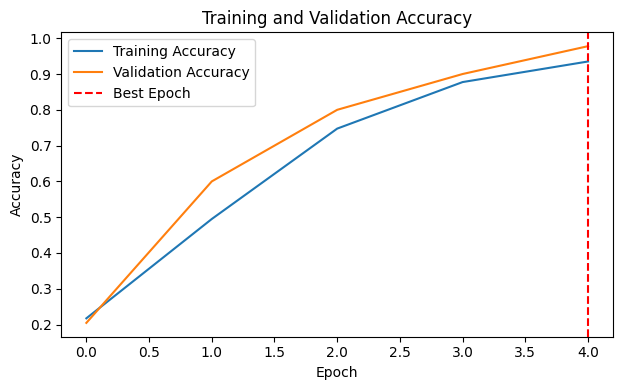

In [17]:
# Plot Accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.axvline(best_epoch-1, color='r', linestyle='--', label='Best Epoch')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

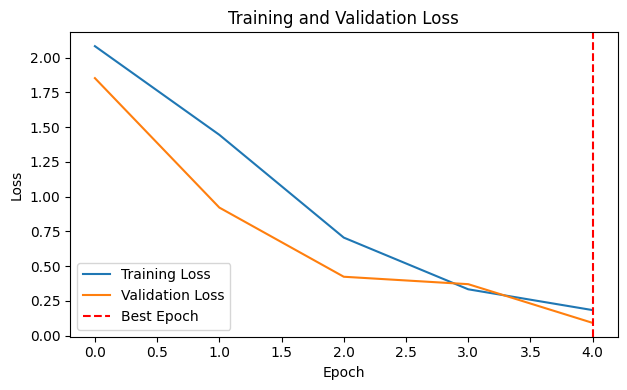

In [18]:
# Plot Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.axvline(best_epoch-1, color='r', linestyle='--', label='Best Epoch')
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

### Confusion Matrix


In [19]:
# create confusion matrix

y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)

75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step


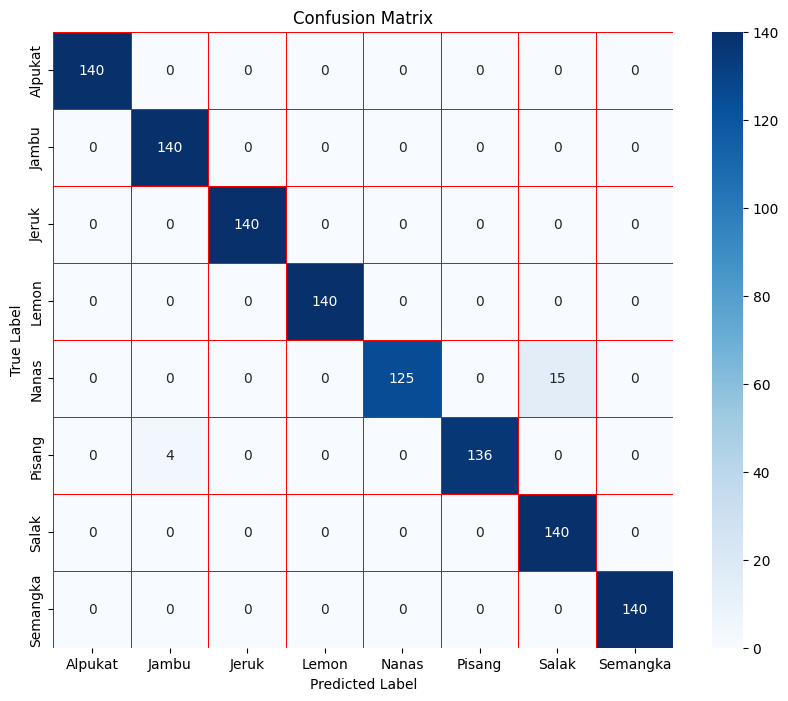

In [20]:
cm = confusion_matrix(y_test, y_pred)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    linewidths=0.5,
    xticklabels=class_names,
    yticklabels=class_names,
    linecolor="red",
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Classification Report


In [21]:
# Classification Report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       140
           1       0.97      1.00      0.99       140
           2       1.00      1.00      1.00       140
           3       1.00      1.00      1.00       140
           4       1.00      0.89      0.94       140
           5       1.00      0.97      0.99       140
           6       0.90      1.00      0.95       140
           7       1.00      1.00      1.00       140

    accuracy                           0.98      1120
   macro avg       0.98      0.98      0.98      1120
weighted avg       0.98      0.98      0.98      1120



# 6. Test Prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


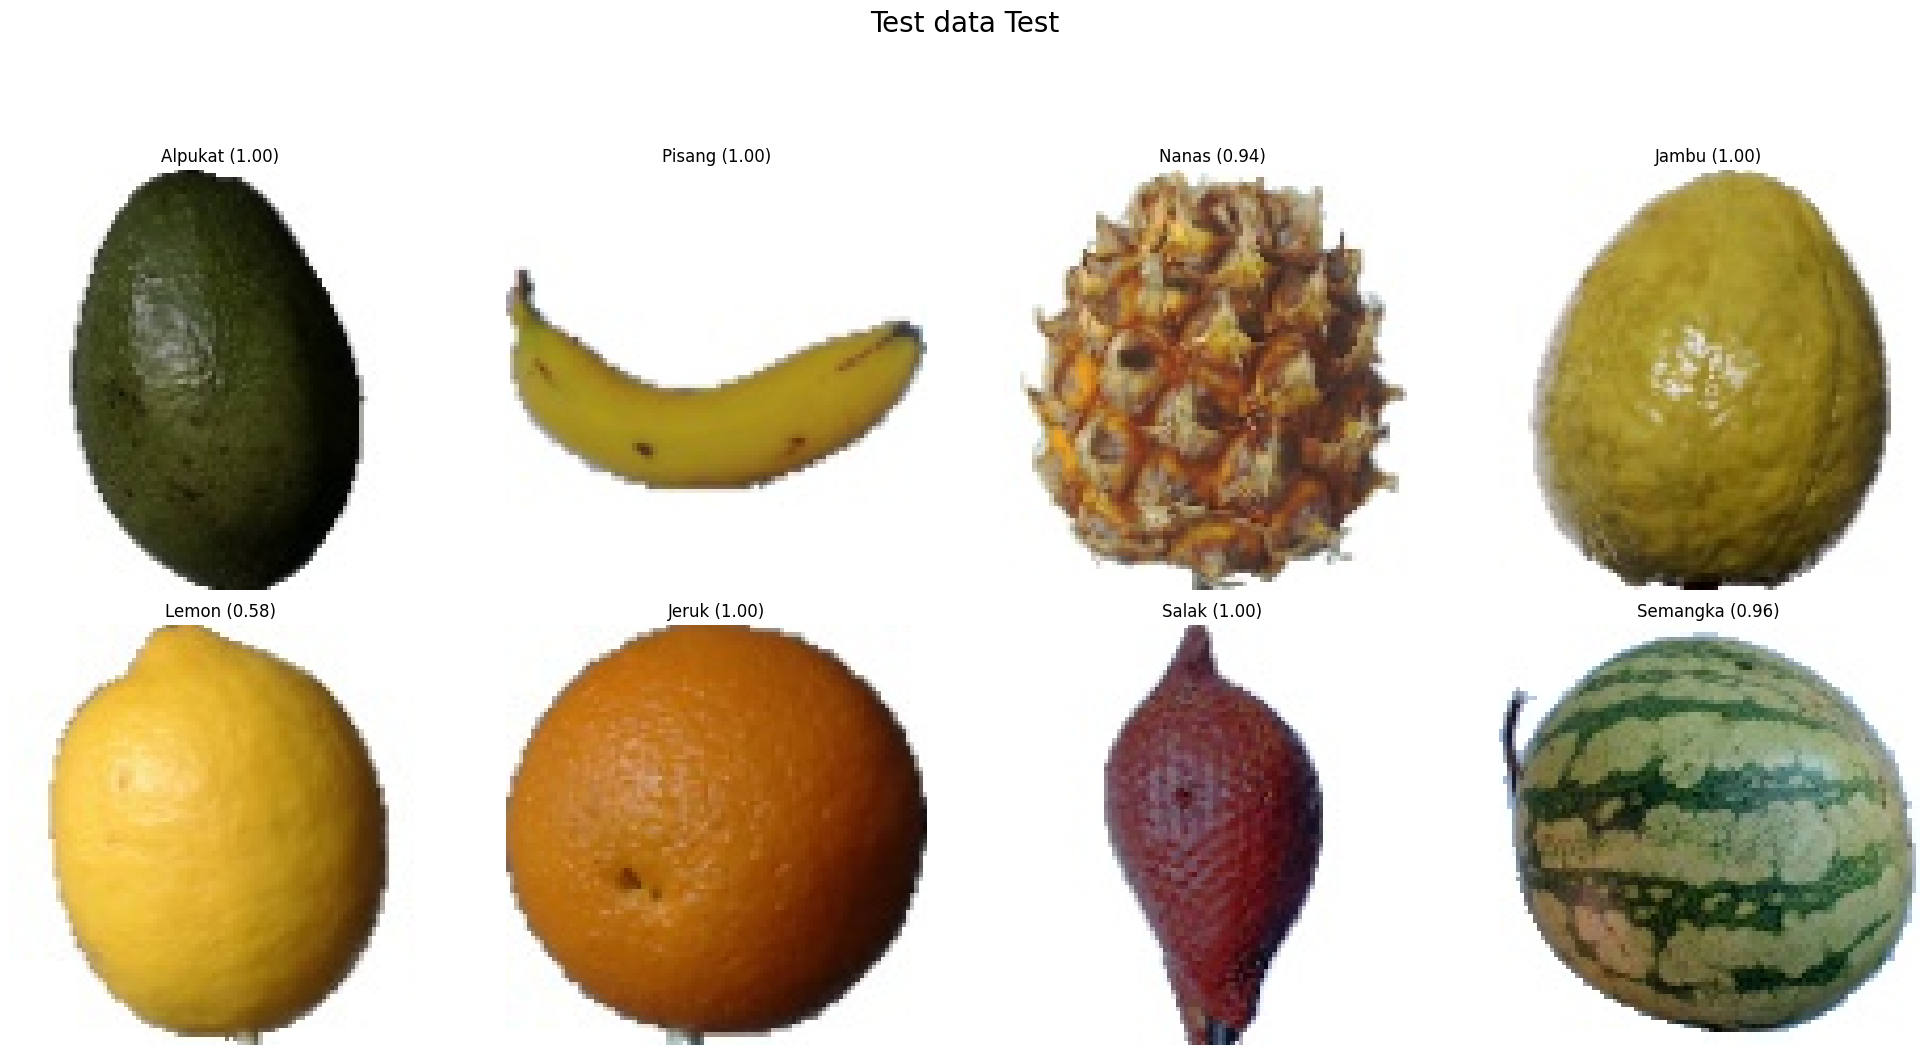

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


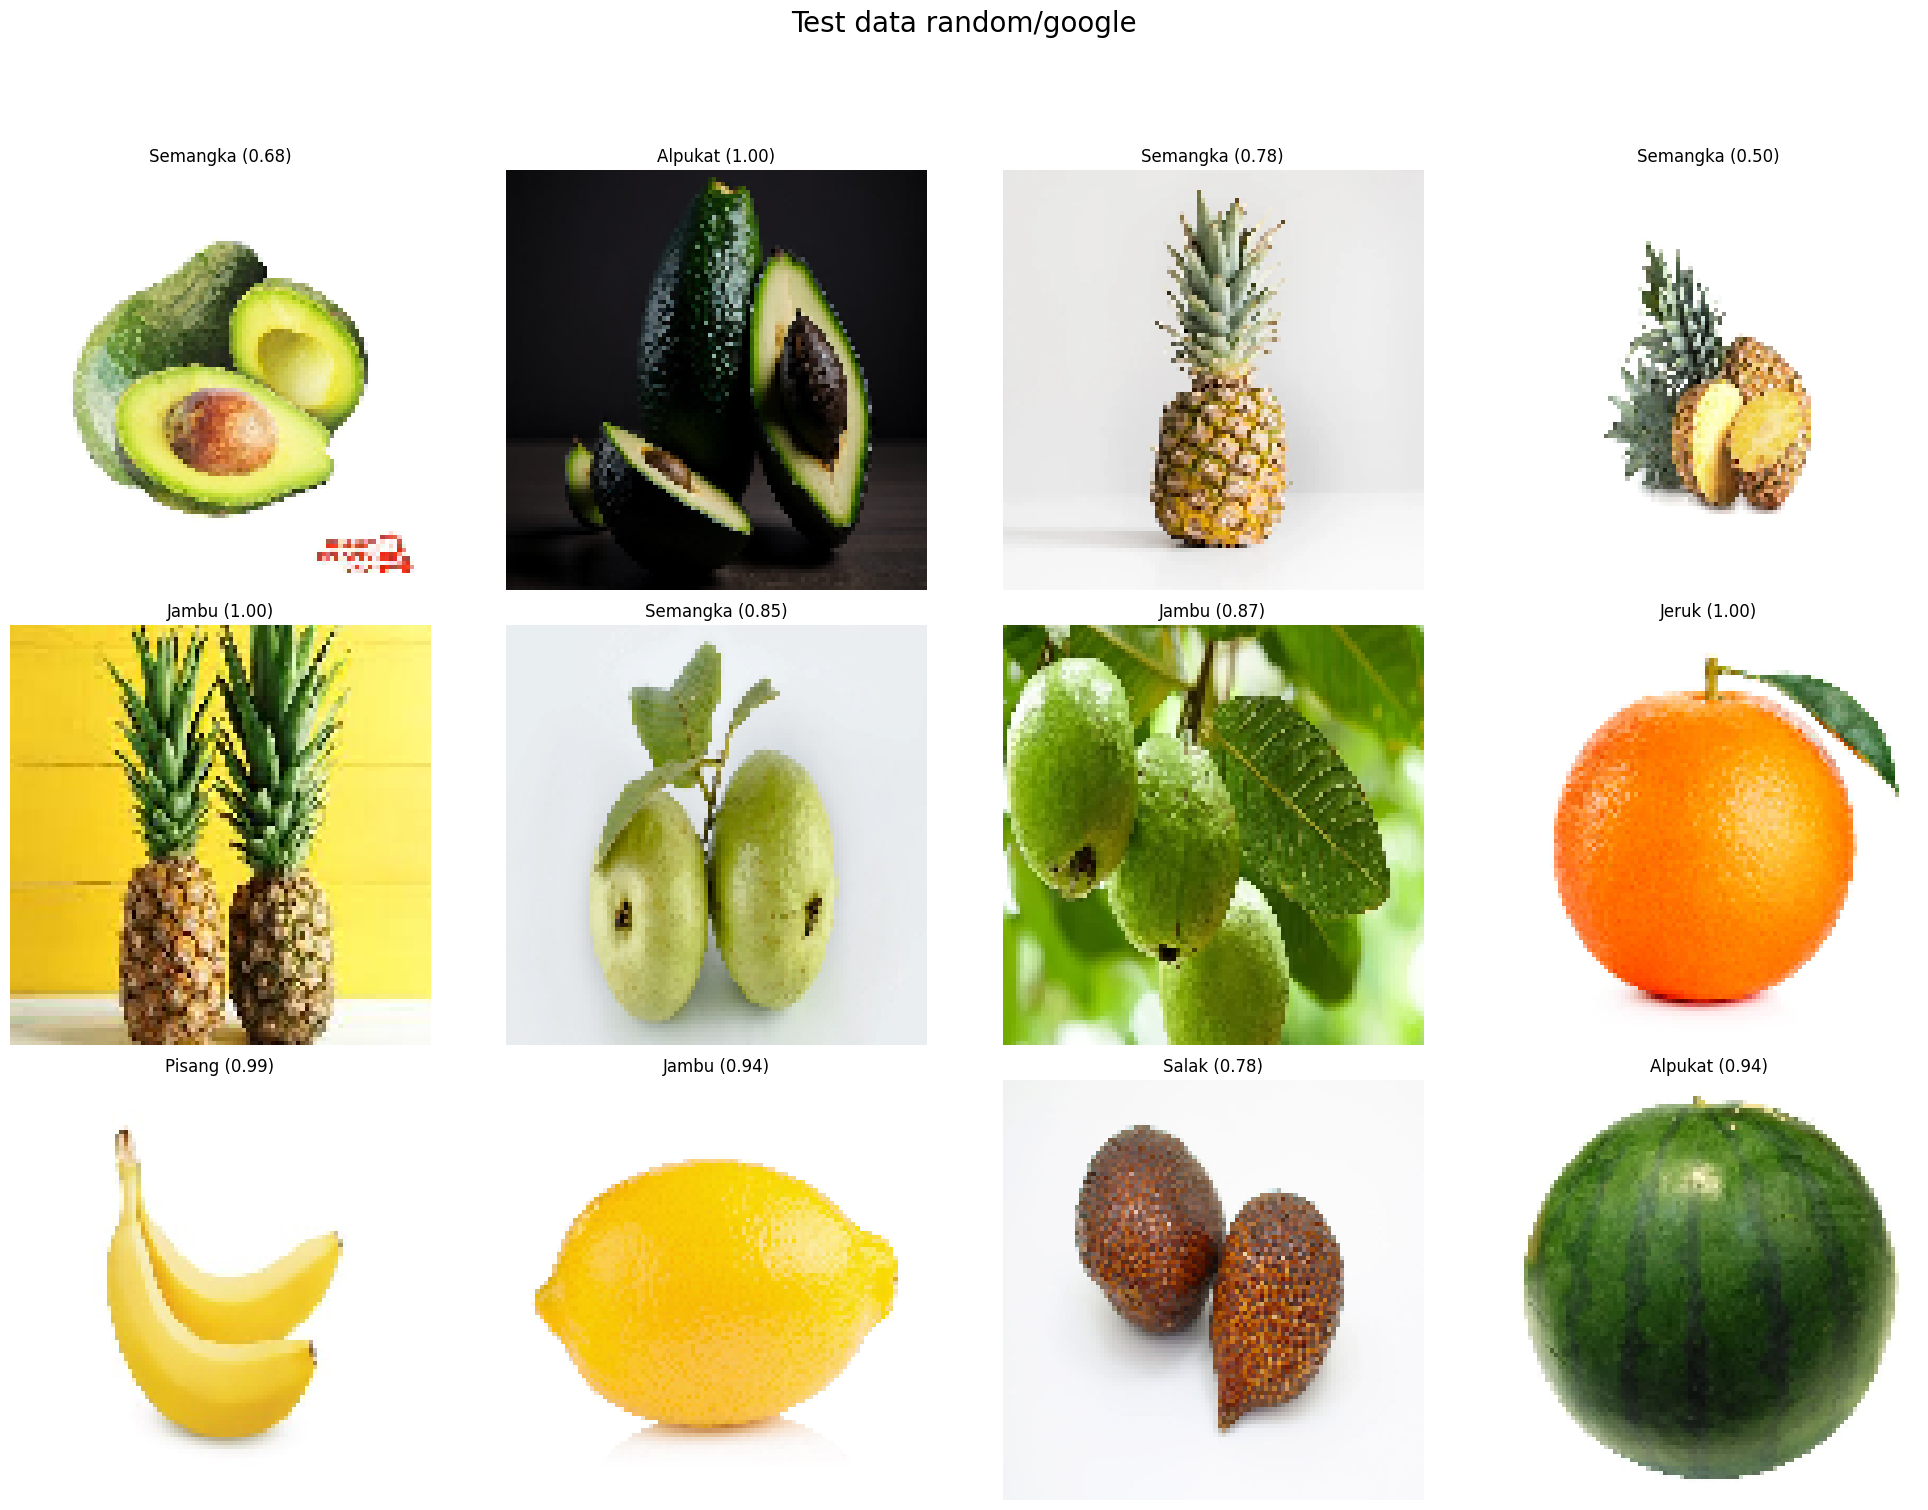

In [22]:
def predict_image(img_path, model, fruits):
    # Memuat dan memproses gambar
    img = image.load_img(img_path, target_size=(100, 100))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    
    # Prediksi gambar
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    predicted_label = [k for k, v in fruits.items() if v == predicted_class][0]
    confidence = np.max(prediction)
    
    return img, predicted_label, confidence

# Daftar gambar untuk prediksi
image_paths = [
    './Dataset/dataset-sendiri/Test/Alpukat/64_100.jpg',
    './Dataset/dataset-sendiri/Test/Pisang/116_100.jpg',
    './Dataset/dataset-sendiri/Test/Nanas/309_100.jpg',
    './Dataset/dataset-sendiri/Test/Jambu/77_100.jpg',
    './Dataset/dataset-sendiri/Test/Lemon/85_100.jpg',
    './Dataset/dataset-sendiri/Test/Jeruk/r_44_100.jpg',
    './Dataset/dataset-sendiri/Test/Salak/r_27_100.jpg',
    './Dataset/dataset-sendiri/Test/Semangka/r_168_100.jpg',
]

# Memisahkan image_paths menjadi dua kategori
dataset_paths = [path for path in image_paths if path.startswith('./Dataset')]
public_paths = [path for path in image_paths if path.startswith('./public')]

# Mendapatkan label dari generator (misalnya train_generator.class_indices)
fruits = train_gen.class_indices

# Fungsi untuk menampilkan gambar dan hasil prediksi
def plot_images(image_paths, title, rows, cols, start_index):
    plt.figure(figsize=(20, 20))
    plt.suptitle(title, fontsize=20)
    
    for i, img_path in enumerate(image_paths):
        img, predicted_label, confidence = predict_image(img_path, model, fruits)
        plt.subplot(rows, cols, start_index + i + 1)
        plt.imshow(img)
        plt.title(f"{predicted_label} ({confidence:.2f})")
        plt.axis("off")
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Adjust title position
    plt.show()

# Menampilkan gambar dari dataset paths
plot_images(dataset_paths, "Test data Test", rows=4, cols=4, start_index=0)

# Menampilkan gambar dari public paths
plot_images(public_paths, "Test data random/google", rows=4, cols=4, start_index=0)